In [3]:
import sys
!{sys.executable} -m pip install pymc

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x2aaaad7446a0>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/pymc/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x2aaaad744898>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/pymc/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x2aaaad7444a8>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/pymc/
^C
Operation cancelled by user


In [2]:
!conda install pymc


CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://repo.anaconda.com/pkgs/r/linux-64/repodata.json.bz2>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.

If your current network has https://www.anaconda.com blocked, please file
a support request with your network engineering team.

ConnectionError(MaxRetryError("HTTPSConnectionPool(host='repo.anaconda.com', port=443): Max retries exceeded with url: /pkgs/r/linux-64/repodata.json.bz2 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x2aaaaeae9668>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"))




In [1]:
import pymc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import corner
%matplotlib inline

ModuleNotFoundError: No module named 'pymc'

## Simple MCMC notebook for two-term power law 
$$ Y = a_1 X**b_1 + a_2 X**b_2 $$
Find a1, b1, a2, b2 given some uncertain obs of Y over some values of X

In [2]:
#..Set up simple power law model function
def two_term_one_dim(a1,a2,b1,b2,xvec):
    pvec = a1*xvec**b1 + a2*xvec**b2
    return pvec

In [3]:
#..Test out this function for from values of xvec
xvec = np.linspace(0.1,100.,500)
pvec = two_term_one_dim(20.,1.,0.1,0.9,xvec)


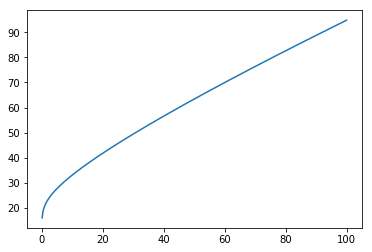

In [4]:
plt.plot(xvec,pvec)

In [17]:
# #..Define variables and priors (bounded uniform)
# a1 = pymc.Uniform('a1',0.,40.)
# a2 = pymc.Uniform('a2',0.,2.)
# b1 = pymc.Uniform('b1',-1.0,1.0)
# b2 = pymc.Uniform('b2',-2.0,2.0)

#..Define variables and priors (bounded uniform, you can try Gaussian too)
a1 = pymc.Uniform('a1',15.,25.)
a2 = pymc.Uniform('a2',0.7,1.3)
b1 = pymc.Uniform('b1',-0.3,0.3)
b2 = pymc.Uniform('b2',0.3,1.3)

#..Define the observation points and the "true" observation
xvec = np.arange(2.0,21.,2)
print(xvec)
truth = np.array([20.,1.,0.1,0.9])
ydata = two_term_one_dim(truth[0],truth[1],truth[2],truth[3],xvec)
print(ydata)

#..Define the model
@pymc.deterministic
def y_model(a1=a1, a2=a2, b1=b1, b2=b2, xvec = xvec):
    pvec = two_term_one_dim(a1,a2,b1,b2,xvec)
    return pvec

#..Define the obs error standard deviation
sigma = 0.02

#..Define the likelihood (multivariate Gaussian w/ diagnonal error variance)
y = pymc.MvNormalCov('y',mu=y_model, C=sigma**2*np.eye(xvec.shape[0]), observed=True, value=ydata)

#..Bundle everything into a dict
model = dict(a1=a1,a2=a2,b1=b1,b2=b2,y_model=y_model,y=y)

[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.]
[ 23.30153523  26.45616935  28.94037679  31.12090744  33.12179058
  35.00150278  36.79275221  38.51589075  40.18454575  41.80834594]
blah
blah


In [ ]:
#..Run using the standard sampler (metropolis sampler with burn-in) w/independent proposal
S = pymc.MCMC(model)
S.sample(iter=2000000, burn=50000)

 [-----------------68%------            ] 1370784 of 2000000 complete in 330.1 sec

In [16]:
#..Run using the Adaptive Metropolis sampler (Haario 2001) w/covarying proposal
#..NOTE: you may need to run the cell two before this again to get this to work
S = pymc.MCMC(model)
S.use_step_method(pymc.AdaptiveMetropolis, [S.a1,S.a2,S.b1,S.b2], delay=10000)
S.sample(iter=2000000, burn=500000)

 [-----------------100%-----------------] 2000000 of 2000000 complete in 268.4 sec

(array([  8.00000000e+00,   0.00000000e+00,   1.50000000e+01,
          8.00000000e+00,   3.40000000e+01,   7.00000000e+01,
          1.09000000e+02,   1.90000000e+02,   3.58000000e+02,
          5.22000000e+02,   1.05600000e+03,   1.54800000e+03,
          2.14200000e+03,   3.17400000e+03,   3.84800000e+03,
          5.40000000e+03,   7.24100000e+03,   8.60800000e+03,
          1.01080000e+04,   1.19490000e+04,   1.30040000e+04,
          1.37860000e+04,   1.47340000e+04,   1.53450000e+04,
          1.71590000e+04,   1.95390000e+04,   2.53100000e+04,
          5.06560000e+04,   1.57510000e+04,   4.57600000e+03,
          1.97400000e+03,   9.26000000e+02,   4.33000000e+02,
          2.73000000e+02,   1.08000000e+02,   2.20000000e+01,
          4.00000000e+00,   5.00000000e+00,   6.00000000e+00,
          1.00000000e+00]),
 array([ -1.13815611e+00,  -1.09748945e+00,  -1.05682279e+00,
         -1.01615613e+00,  -9.75489475e-01,  -9.34822815e-01,
         -8.94156156e-01,  -8.53489496e-01

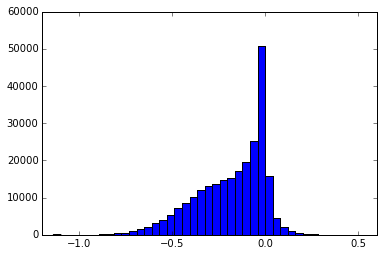

In [93]:
#..Some stats
plt.hist(S.trace('y_model')[:,0],bins=40)

(4, 1500000)


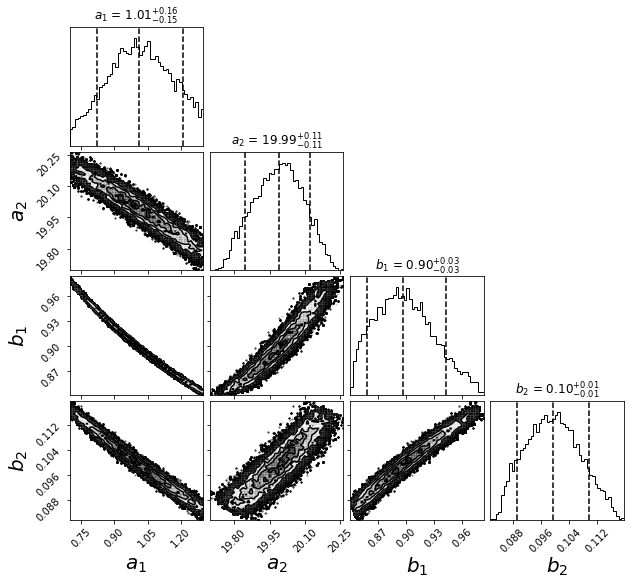

In [19]:
#..Plot the posterior joint parameter PDF (as a 2D and 1D marginal corner plot)

labels  = ['$a_1$', '$a_2$','$b_1$','$b_2$']
#samples = np.vstack((S.trace('a1')[:],S.trace('a2')[:],S.trace('b1')[:],S.trace('b2')[:]))
samples = np.vstack((S.trace('a2')[:],S.trace('a1')[:],S.trace('b2')[:],S.trace('b1')[:]))
print(samples.shape)

#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(5,5,1)
#plt.plot([0,1],[0,1])
label_kwargs = {'fontsize':'20'}
#fig = triangle.corner(samples.T,labels=labels,truths=truth,label_kwargs=label_kwargs)
# fig,axes = triangle.corner(samples.T,labels=labels,truths=truth,
#                       quantiles=[.1,.5,.9],truth_color='r',
#                       show_titles=True,
#                       bins=50,
#                       label_kwargs=label_kwargs,return_axes=True)


#..NOTE the default behavior only returns fig
#fig,axes = corner.corner(samples.T,labels=labels,truths=truth,
fig = corner.corner(samples.T,labels=labels,truths=truth,
                      quantiles=[.1,.5,.9],truth_color='r',
                      show_titles=True,
                      bins=50,
                      label_kwargs=label_kwargs)
fig.set_size_inches(9,8)

fig.savefig('mcmc_twoterm_lowerr10.png',dpi=150)
#fig.suptitle('Damped Harmonic Oscillator parameter uncertainty', fontsize=22,fontweight='bold',y=1.05)
#fig.savefig('mcmc_dampharm.png',dpi=150)